In [2]:
import os
import networkx as nx
import numpy as np
import heapq
import pandas as pd
import time
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg
import random
import math

def read_txt_network(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            nodes = line.strip().split()
            if len(nodes) == 2:
                edges.append((int(nodes[0]), int(nodes[1])))
    return edges

def Bonacich_centrality_zip(G, pr):
    adj_matrix = nx.adjacency_matrix(G)
    N = G.number_of_nodes()
    
    pre = pr * adj_matrix.toarray()  # Convert sparse matrix to dense array for np.linalg.matrix_power
    pre_Matrix = np.zeros_like(pre)
    
    for i in range(1, 5):  # Accumulate matrix powers from 1 to 4
        pre_Matrix += np.linalg.matrix_power(pre, i)
        
    Bonacich_centrality = pre_Matrix @ np.ones(N)
    Bonacich_centrality = np.round(Bonacich_centrality, 2)
    
    return dict(zip(G.nodes(), Bonacich_centrality))

def ICsim(G, decision_dict , pr, num_iterations):
    results = []  # Store (selected_nodes, decision_combinations, activated_count)
    selected_nodes = list(decision_dict.keys())
    decisions = list(decision_dict.values())
    
    total_activated = 0  # Track the total number of activations across iterations
    for _ in range(num_iterations):
        initial_seeding = [node for node, freq in zip(selected_nodes, decisions) if np.random.rand() < freq]
        
        if not initial_seeding:
            continue

        node_statuses = {node: 1 if node in initial_seeding else 0 for node in G.nodes()}
        next_nodes = list(initial_seeding)  # Stack to store nodes to be processed in next iteration
        activated_count = len(initial_seeding)  # Include initially activated nodes

        # Perform cascade propagation
        while next_nodes:
            current_node = next_nodes.pop()
            for ne in G.successors(current_node):
                # Activate neighbor with probability pr
                if node_statuses[ne] == 0 and np.random.rand() < pr:
                    node_statuses[ne] = 1
                    next_nodes.append(ne)
                    activated_count += 1

        total_activated += activated_count

    expected_activate = total_activated / num_iterations
    
    return expected_activate

def find_activation_plan(G, demands, pr, num_iterations):
    nodes_sorted_by_outdegree = sorted(G.nodes(), key=lambda node: G.out_degree(node), reverse=True)
    
    decision_plan = []
    total_decision_dict = {node: 0 for node in G.nodes()}
    costs = []
    activations = []

    for demand in demands:
        current_decision_dict = {}
        accumulated_activation = 0
        node_index = 0
        cost = 0
        
        while accumulated_activation < demand and node_index < len(nodes_sorted_by_outdegree):
            current_node = nodes_sorted_by_outdegree[node_index]
            remaining_frequency = 1 - total_decision_dict[current_node]-0.01
            
            if remaining_frequency > 0:
                current_decision_dict[current_node] = remaining_frequency
                current_activation = ICsim(G, current_decision_dict, pr, num_iterations)
                
                if current_activation > demand:
                    needed_frequency = min((demand - accumulated_activation)/(current_activation-accumulated_activation),remaining_frequency)
                    current_decision_dict[current_node] = needed_frequency
                    total_decision_dict[current_node] += needed_frequency
                    accumulated_activation=demand
                else:
                    accumulated_activation = current_activation
                    total_decision_dict[current_node] = 1
                
                cost += G.out_degree(current_node) * round(current_decision_dict[current_node], 2)
            
            node_index += 1
        
        for key, value in current_decision_dict.items():
            current_decision_dict[key] = round(value, 2)
        current_activation = ICsim(G, current_decision_dict, pr, num_iterations)    
        decision_plan.append(current_decision_dict)
        costs.append(cost)
        activations.append(current_activation)
    
    return decision_plan, costs, activations

def n_Choices(G, k, n, pr, num_iterations):
    results = []  # Store (selected_nodes, decision_combinations, activated_count)
    N = G.number_of_nodes()
    
    # Filter out nodes with centrality <= 10
    filtered_rank_list = [node for node in G.nodes() if G.out_degree(node) > 10]
    
    for _i in range(10):
        Decisions = generate_random_numbers(k, n)
        for choose in range(200):
            selected = random.sample(filtered_rank_list, n)
            for frequency in Decisions:
                expected_activate = 0
                for __ in range(num_iterations):
                    initial_seeding = []
                    for __i in range(n):
                        if np.random.rand() < frequency[__i]:
                            initial_seeding.append(selected[__i])
                            
                    if not initial_seeding:
                        continue
                        
                    node_statuses = {node: 1 if node in initial_seeding else 0 for node in G.nodes()}
                    next_nodes = list(initial_seeding)  # Stack to store nodes to be processed in next iteration
                    activated_count = len(initial_seeding)  # Include initially activated nodes
                        
                    # Perform cascade propagation
                    while next_nodes:
                        current_node = next_nodes.pop()
                        for ne in G.neighbors(current_node):
                            # Activate neighbor with probability a
                            if node_statuses[ne] == 0 and np.random.rand() < pr:
                                node_statuses[ne] = 1
                                next_nodes.append(ne)
                                activated_count += 1
                    expected_activate += activated_count
                                        
                expected_activate /= num_iterations
                result = {
                    "sel": selected,
                    "dec": frequency.tolist(),
                    "act": expected_activate
                }

                results.append(result)
                
    return results

def cost_calcu(G, decision_dict):
    selected_nodes = list(decision_dict.keys())
    print(selected_nodes)
    decisions = list(decision_dict.values())
    print(decisions)
    cost = 0
    ind=0
    for _ in selected_nodes:
        cost += G.out_degree(_)*decisions[ind]
        ind+=1
    print(f"Total cost: {cost}")

def compute_rho(M, tol=1e-4):
    n = M.shape[0]
    Ones = np.ones_like(M)
    ones = np.ones(n)
    M_t= M.T
    
    rho_prev = np.zeros_like(M)
    rho = M.copy()
    Rho = Ones - rho
    
    for k in range(1, 10):
        for i in range(n):
            for j in range(n):
                if i!=j:
                    rho_prev = ones - rho[i,:] * M_t[j,:] 
                    rho[i,j] = 1 - np.prod(rho_prev)
                    
        if np.allclose(rho, rho_prev, atol=tol):
            break

        rho_prev = rho.copy()
        Rho *= (Ones-rho)
    print('num_iterations = ',k)
    Rho = Ones - Rho
    return Rho

def Expected_Activated_Matrix(G,decision_dict,Rho):
    Rho = np.copy(Rho)
    nodes_list = list(G.nodes())
    selected_nodes = list(decision_dict.keys())
    decisions = list(decision_dict.values())
    index = [nodes_list.index(node) for node in selected_nodes]
    Exp = sum(decisions)
    
    for i in range(len(index)):
        Rho[index[i]] *= decisions[i]
    
    for o in range(Rho.shape[0]):
        if o not in index:
            _ = 1
            for i in index:
                _ *= 1-Rho[i,o]
            Exp += 1-_
            
    return Exp   

pr = 0.1  # 设定的参数
num_iterations=80

In [3]:
def generate_random_numbers(k, n):
    integers = np.random.randint(1, 11, size=(k, n))  
    decimals = integers / 10.0
    return decimals

def get_top_m_indices_zip(centrality_dict, m):
    # Sort the dictionary by value and get the top m keys (nodes)
    sorted_nodes = sorted(centrality_dict, key=centrality_dict.get, reverse=True)
    return sorted_nodes[:m]

def yunLang_centrality_zip(G, rho):
    N = G.number_of_nodes()
    centrality = rho @ np.ones(N)
    return dict(zip(G.nodes(),centrality))

def Calcul_Residual(G, rho, pr, k, n):
    
    results = []  # Store (exp_act, residual)
    N = G.number_of_nodes()
    centrality = yunLang_centrality_zip(G, rho)
    rank_list = get_top_m_indices_zip(centrality, N)
    
    indices = {value: index for index, value in enumerate(G.nodes())}
    
    for _i in range(10):
        Decisions = generate_random_numbers(k, n)
        for choose in range(100):
            selected = random.sample(rank_list, n)
            for frequency in Decisions:
                decision_dict = dict(zip(selected, frequency))
                exp = Expected_Activated_Matrix(G, decision_dict, rho)
                first = sum(frequency[i] * centrality[selected[i]] for i in range(n))
                selected_rows = rho[[indices[node] for node in selected], :]
                second = 0
                for i in range(len(selected)):
                    for j in range(i, len(selected)):  
                        inner_product =  frequency[i] * frequency[j] * np.dot(selected_rows[i], selected_rows[j])
                        second -= inner_product
            
                act = ICsim(G, decision_dict , pr, 100)
                
                results.append([act, exp, first, second])
    
    return results

import re

def Calcul_EP(G, rho, file_path):
    results = []  # Store (act, exp, first, second)
    pattern = r'sel:\s*\[(.*?)\]\s*dec:\s*\[(.*?)\]\s*act:\s*(\d+\.\d+)'
    N = G.number_of_nodes()
    indices = {value: index for index, value in enumerate(G.nodes())}
    centrality = yunLang_centrality_zip(G, rho)
    
    with open(file_path, 'r') as file:
        for line in file:
            match = re.match(pattern, line)

            if not match:
                raise ValueError(f"Invalid line format: {line}")
                
            sel_part, dec_part, act_part = match.groups()

            selected = [int(node.strip()) for node in sel_part.split(',')]

            frequency = [float(freq.strip()) for freq in dec_part.split(',')]

            act = float(act_part)
            
            decision_dict = dict(zip(selected, frequency))

            exp = Expected_Activated_Matrix(G, decision_dict, rho)
            
            first = sum(frequency[i] * centrality[selected[i]] for i in range(len(selected)))
            
            selected_rows = rho[[indices[node] for node in selected], :]
            
            second = 0
            for i in range(len(selected)):
                for j in range(i, len(selected)):  
                    inner_product = frequency[i] * frequency[j] * np.dot(selected_rows[i], selected_rows[j])
                    second -= inner_product
            
            results.append([act, exp, first, second])
    
    return results

## <center>Simulation Data: {Selected node: activation frequency} <center>

In [133]:
current_dir = os.getcwd()

folder_name = "Instance"
output_folder = "New_instance"
folder_path = os.path.join(current_dir, folder_name)
output_path = os.path.join(current_dir, output_folder)

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    edges = read_txt_network(file_path)
    G = nx.DiGraph()
    G.add_edges_from(edges)
    split_file = os.path.splitext(filename)
    for num_choice in [1, 5, 10]:
        start_time = time.time()
        result = n_Choices(G, 5, num_choice, pr, num_iterations)
        new_filename = f"{num_choice}_{split_file[0]}{split_file[1]}"
        with open(os.path.join(output_path, new_filename), 'w') as file:
            for item in result:
                file.write(f'sel: {item["sel"]} dec: {item["dec"]} act: {item["act"]}\n')
        end_time = time.time()
        run_time = end_time - start_time
        run_time_min = run_time / 60
        print(new_filename + " Running time：", run_time_min, "minutes")

1_socfb-American75.txt Running time： 32.724305899937946 minutes
5_socfb-American75.txt Running time： 124.83305214246114 minutes
10_socfb-American75.txt Running time： 159.77949680487316 minutes
1_socfb-Amherst41.txt Running time： 17.8501234292984 minutes
5_socfb-Amherst41.txt Running time： 57.92781184116999 minutes
10_socfb-Amherst41.txt Running time： 112.70347044865291 minutes
1_socfb-Bingham82.txt Running time： 43.977257164319354 minutes
5_socfb-Bingham82.txt Running time： 149.60311185916265 minutes
10_socfb-Bingham82.txt Running time： 241.34197372198105 minutes
1_socfb-Bowdoin47.txt Running time： 10.880303875605266 minutes
5_socfb-Bowdoin47.txt Running time： 41.628664334615074 minutes
10_socfb-Bowdoin47.txt Running time： 62.63420985937118 minutes
1_socfb-Brandeis99.txt Running time： 19.39300972620646 minutes
5_socfb-Brandeis99.txt Running time： 68.89000729719798 minutes
10_socfb-Brandeis99.txt Running time： 103.40199377139409 minutes
1_socfb-Caltech36.txt Running time： 2.411782463391

In [4]:
current_dir = os.getcwd()

folder_name = "Test"
output_folder = "New_instance"
folder_path = os.path.join(current_dir, folder_name)
output_path = os.path.join(current_dir, output_folder)

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    edges = read_txt_network(file_path)
    G = nx.DiGraph()
    G.add_edges_from(edges)
    split_file = os.path.splitext(filename)
    for num_choice in [1]:
        start_time = time.time()
        result = n_Choices(G, 5, num_choice, pr, num_iterations)
        new_filename = f"{num_choice}_{split_file[0]}{split_file[1]}"
        with open(os.path.join(output_path, new_filename), 'w') as file:
            for item in result:
                file.write(f'sel: {item["sel"]} dec: {item["dec"]} act: {item["act"]}\n')
        end_time = time.time()
        run_time = end_time - start_time
        run_time_min = run_time / 60
        print(new_filename + " Running time：", run_time_min, "minutes")

1_socfb-Haverford76.txt Running time： 12.390409088134765 minutes
1_socfb-Reed98.txt Running time： 3.1507312417030335 minutes


In [13]:
current_dir = os.getcwd()
folder_name = "New_test"
output_folder = "ForPaper"
folder_path = os.path.join(current_dir, folder_name)
output_path = os.path.join(current_dir, output_folder)

if not os.path.exists(output_path):
    os.makedirs(output_path)

for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    
    if os.path.isdir(subfolder_path):
        socfb_file = None
        other_files = []
        
        for file in os.listdir(subfolder_path):
            if file.startswith("socfb"):
                socfb_file = file
            else:
                other_files.append(file)
        
        if socfb_file is None:
            print(f"Warning: No socfb file found in {subfolder}")
            continue
        
        socfb_file_path = os.path.join(subfolder_path, socfb_file)
        start_time = time.time()
        edges = read_txt_network(socfb_file_path)
        G = nx.DiGraph()
        G.add_edges_from(edges)
        adj_matrix = nx.adjacency_matrix(G)
        pre = pr * adj_matrix.toarray()  # 注意这里假设pr是已定义的变量
        rho = compute_rho(pre)
        end_time = time.time()
        run_time = end_time - start_time
        run_time_min = run_time / 60
        print(f"Compute Rho for {subfolder}: {run_time_min:.2f} minutes")

        for filename in other_files:
            file_path = os.path.join(subfolder_path, filename)
            start_time = time.time()
            result = Calcul_EP(G, rho, file_path)
            
            new_filename = f"{filename}_result.txt"
            
            with open(os.path.join(output_path, new_filename), 'w') as file:
                for item in result:
                    line = ' '.join(map(str, item))
                    file.write(line + '\n')
            
            end_time = time.time()
            run_time = end_time - start_time
            run_time_min = run_time / 60
            print(f"{new_filename} Running time: {run_time_min:.2f} minutes")
        
        rho_filename = f"{subfolder}_rho.txt"
        np.savetxt(os.path.join(output_path, rho_filename), rho)

num_iterations =  9
Compute Rho for Amherst41: 29.04 minutes
num_iterations =  9
Compute Rho for Bowdoin47: 34.04 minutes
20_socfb-Bowdoin47.txt_result.txt Running time: 5.92 minutes
num_iterations =  9
Compute Rho for Caltech36: 1.21 minutes
20_socfb-Caltech36.txt_result.txt Running time: 1.48 minutes


In [16]:
current_dir = os.getcwd()

# 定义路径
folder_name = r"F:\Jupyter\Social network\New_test\Amherst41"
output_folder = "ForPaper"
folder_path = folder_name  # 直接使用绝对路径
output_path = os.path.join(current_dir, output_folder)

# 确保输出目录存在
if not os.path.exists(output_path):
    os.makedirs(output_path)

# 从文件中读取 rho 矩阵
rho_file_path = r'F:\Jupyter\Social network\ForPaper\Amherst41_rho.txt'
rho = np.loadtxt(rho_file_path)

network_name = 'socfb-Amherst41.txt'
network_path = os.path.join(folder_path, network_name)
# 定义要处理的文件名
filename = '20_socfb-Amherst41.txt'
file_path = os.path.join(folder_path, filename)

# 读取网络并创建有向图 G
edges = read_txt_network(network_path)
G = nx.DiGraph()
G.add_edges_from(edges)

# 计算结果
start_time = time.time()
result = Calcul_EP(G, rho, file_path)

# 保存结果到新文件
new_filename = f"{filename}_result.txt"
with open(os.path.join(output_path, new_filename), 'w') as file:
    for item in result:
        line = ' '.join(map(str, item))
        file.write(line + '\n')

end_time = time.time()
run_time = end_time - start_time
run_time_min = run_time / 60
print(f"{new_filename} Running time: {run_time_min:.2f} minutes")

20_socfb-Amherst41.txt_result.txt Running time: 6.26 minutes


In [15]:
current_dir = os.getcwd()
folder_name = "New_instance"
output_folder = "ForPaper"
folder_path = os.path.join(current_dir, folder_name)
output_path = os.path.join(current_dir, output_folder)

if not os.path.exists(output_path):
    os.makedirs(output_path)

for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    
    if os.path.isdir(subfolder_path):
        socfb_file = None
        other_files = []
        
        for file in os.listdir(subfolder_path):
            if file.startswith("socfb"):
                socfb_file = file
            else:
                other_files.append(file)
        
        if socfb_file is None:
            print(f"Warning: No socfb file found in {subfolder}")
            continue
        
        socfb_file_path = os.path.join(subfolder_path, socfb_file)
        start_time = time.time()
        edges = read_txt_network(socfb_file_path)
        G = nx.DiGraph()
        G.add_edges_from(edges)
        adj_matrix = nx.adjacency_matrix(G)
        pre = pr * adj_matrix.toarray()
        rho = compute_rho(pre)
        end_time = time.time()
        run_time = end_time - start_time
        run_time_min = run_time / 60
        print(f"Compute Rho for {subfolder}: {run_time_min:.2f} minutes")

        for filename in other_files:
            file_path = os.path.join(subfolder_path, filename)
            start_time = time.time()
            result = Calcul_EP(G, rho, file_path)
            
            new_filename = f"{filename}_result.txt"
            
            with open(os.path.join(output_path, new_filename), 'w') as file:
                for item in result:
                    line = ' '.join(map(str, item))
                    file.write(line + '\n')
            
            end_time = time.time()
            run_time = end_time - start_time
            run_time_min = run_time / 60
            print(f"{new_filename} Running time: {run_time_min:.2f} minutes")

KeyboardInterrupt: 

## <center>Plot residual<center>

In [19]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math

# 输入和输出文件夹路径
input_folders = ["F:/Jupyter/Social network/ForPaper/plot/Caltech36",
                 "F:/Jupyter/Social network/ForPaper/plot/Bowdoin47",
                 "F:/Jupyter/Social network/ForPaper/plot/Amherst41"]
#                  
#                  "F:/Jupyter/Social network/ForPaper/plot/Bowdoin47",
output_folder = "F:/Jupyter/Social network/ForPaper"
categories = [ 'Caltech36','Bowdoin47','Amherst41'] 
#'American75','Amherst41','Bowdoin47',
os.makedirs(output_folder, exist_ok=True)
parameter = [5, 10, 20]
title_font = {
    'size': 40,
    'weight': 'bold',
    'family': 'serif',
    'color': 'blue'
}

for i, folder in enumerate(input_folders):
    files = sorted([f for f in os.listdir(folder) if f.endswith('.txt')], key=lambda x: int(x.split('_')[0]))
    results_ea = {5: [], 10: [], 20: []}
    results_eX = {5: [], 10: [], 20: []}
    coef_eX = {5: [], 10: [], 20: []}
    all_re_exp = []
    _ = 0
    for filename in files:
        print(filename)
        file_path = os.path.join(folder, filename)
        data = pd.read_csv(file_path, sep=' ', header=None)

        act = data.iloc[:, 0]
        re_exp = data.iloc[:, 1]
        X = data.iloc[:, 2:]
#         print([x for x in re_exp if x<5])
        
        lin_reg_ea = LinearRegression()
        lin_reg_ea.fit(re_exp.values.reshape(-1, 1), act)
        re_exp_pred = lin_reg_ea.predict(re_exp.values.reshape(-1, 1))

        residuals_ea = list(zip(re_exp, act - re_exp_pred))
        results_ea[parameter[_]].extend(residuals_ea)

        lin_reg_eX = LinearRegression()
        lin_reg_eX.fit(X, re_exp)
        re_X = lin_reg_eX.predict(X)
        coef_eX[parameter[_]] = lin_reg_eX.coef_
        residuals_eX = list(zip(re_exp, re_X - re_exp))
        results_eX[parameter[_]].extend(residuals_eX)

        all_re_exp.append(re_exp)
        _ += 1

    factor = 3
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for idx, param in enumerate(parameter):
        x_min = min(all_re_exp[idx]) - 10
        x_max = max(all_re_exp[idx]) + 10
        re_exp = [pair[0] for pair in results_ea[param]]
        residuals_ea = [pair[1] for pair in results_ea[param]]
        residuals_eX = [pair[1] for pair in results_eX[param]]

        relative_residuals_ea = np.array(residuals_ea) / np.array(re_exp)
        relative_residuals_eX = np.array(residuals_eX) / np.array(re_exp)

        mae_ea = np.mean(np.abs(relative_residuals_ea))
        std_dev_ea = np.std(relative_residuals_ea)
        mae_eX = np.mean(np.abs(relative_residuals_eX))
        std_dev_eX = np.std(relative_residuals_eX)

        mask_ea = (relative_residuals_ea >= -factor * std_dev_ea) & (relative_residuals_ea <= factor * std_dev_ea)
        mask_eX = (relative_residuals_eX >= -factor * std_dev_eX) & (relative_residuals_eX <= factor * std_dev_eX)
        mask = mask_ea & mask_eX

        re_exp = np.array(re_exp)[mask]
        relative_residuals_ea = relative_residuals_ea[mask]
        relative_residuals_eX = relative_residuals_eX[mask]
        
        ea_label = f'Simulation vs. Expectation'
        ex_label = f'Expectation vs. SEA Regression'
        axes[idx].scatter(re_exp, relative_residuals_ea, marker='D', s=70, c='red', edgecolor='black', alpha=0.6, label=ea_label)
        axes[idx].scatter(re_exp, relative_residuals_eX, marker='o', s=70, c='blue', edgecolor='black', alpha=0.6, label=ex_label)
        axes[idx].axhline(y=0, color='r', linestyle='--')
        axes[idx].set_xlim(x_min, x_max + 10)
        axes[idx].set_ylim(-1, 1)
        axes[idx].set_xlabel('Expected Value')
        axes[idx].set_ylabel('Relative Residuals')
        axes[idx].set_title(f'n={param}, MAE(SE)={mae_ea:.2f}, STD(SE)={std_dev_ea:.2f}\nMAE(ER)={mae_eX:.2f}, STD(ER)={std_dev_eX:.2f},OLS: {round(coef_eX[param][0],2),round(coef_eX[param][1],2)}')
        axes[idx].legend()

    plt.suptitle(f'Residual Plot for {categories[i]}', fontdict=title_font)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(output_folder, f'network_{i+1}_residual_plot.png'))
    plt.close()

5_socfb-Caltech36.txt_result.txt
10_socfb-Caltech36.txt_result.txt
20_socfb-Caltech36.txt_result.txt
5_socfb-Bowdoin47.txt_result.txt
10_socfb-Bowdoin47.txt_result.txt
20_socfb-Bowdoin47.txt_result.txt
5_socfb-Amherst41.txt_result.txt
10_socfb-Amherst41.txt_result.txt
20_socfb-Amherst41.txt_result.txt


## <center> No Regression <center>

In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math

# 输入和输出文件夹路径
input_folders = ["F:/Jupyter/Social network/ForPaper/plot/Caltech36",
                 "F:/Jupyter/Social network/ForPaper/plot/Bowdoin47",
                 "F:/Jupyter/Social network/ForPaper/plot/Amherst41"]
#                  
#                  "F:/Jupyter/Social network/ForPaper/plot/Bowdoin47",
output_folder = "F:/Jupyter/Social network/ForPaper"
categories = [ 'Caltech36','Bowdoin47','Amherst41'] 
#'American75','Amherst41','Bowdoin47',
os.makedirs(output_folder, exist_ok=True)
parameter = [5, 10, 20]
title_font = {
    'size': 40,
    'weight': 'bold',
    'family': 'serif',
    'color': 'blue'
}

for i, folder in enumerate(input_folders):
    files = sorted([f for f in os.listdir(folder) if f.endswith('.txt')], key=lambda x: int(x.split('_')[0]))
    results_ea = {5: [], 10: [], 20: []}
    results_eX = {5: [], 10: [], 20: []}
    coef_eX = {5: [], 10: [], 20: []}
    all_re_exp = []
    _ = 0
    for filename in files:
        print(filename)
        file_path = os.path.join(folder, filename)
        data = pd.read_csv(file_path, sep=' ', header=None)

        act = data.iloc[:, 0]
        re_exp = data.iloc[:, 1]
        X = data.iloc[:, 2:]
#         print([x for x in re_exp if x<5])
        
#         lin_reg_ea = LinearRegression()
#         lin_reg_ea.fit(re_exp.values.reshape(-1, 1), act)
#         re_exp_pred = lin_reg_ea.predict(re_exp.values.reshape(-1, 1))

#         residuals_ea = list(zip(re_exp, act - re_exp_pred))
        residuals_ea = list(zip(re_exp, act - re_exp))
        results_ea[parameter[_]].extend(residuals_ea)

        lin_reg_eX = LinearRegression()
        lin_reg_eX.fit(X, re_exp)
        re_X = lin_reg_eX.predict(X)
        coef_eX[parameter[_]] = lin_reg_eX.coef_
        residuals_eX = list(zip(re_exp, re_X - re_exp))
        results_eX[parameter[_]].extend(residuals_eX)

        all_re_exp.append(re_exp)
        _ += 1

    factor = 3
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for idx, param in enumerate(parameter):
        x_min = min(all_re_exp[idx]) - 10
        x_max = max(all_re_exp[idx]) + 10
        re_exp = [pair[0] for pair in results_ea[param]]
        residuals_ea = [pair[1] for pair in results_ea[param]]
        residuals_eX = [pair[1] for pair in results_eX[param]]

        relative_residuals_ea = np.array(residuals_ea) / np.array(re_exp)
        relative_residuals_eX = np.array(residuals_eX) / np.array(re_exp)

        mae_ea = np.mean(np.abs(relative_residuals_ea))
        std_dev_ea = np.std(relative_residuals_ea)
        mae_eX = np.mean(np.abs(relative_residuals_eX))
        std_dev_eX = np.std(relative_residuals_eX)

        mask_ea = (relative_residuals_ea >= -factor * std_dev_ea) & (relative_residuals_ea <= factor * std_dev_ea)
        mask_eX = (relative_residuals_eX >= -factor * std_dev_eX) & (relative_residuals_eX <= factor * std_dev_eX)
        mask = mask_ea & mask_eX

        re_exp = np.array(re_exp)[mask]
        relative_residuals_ea = relative_residuals_ea[mask]
        relative_residuals_eX = relative_residuals_eX[mask]
        
        ea_label = f'Simulation vs. Expectation'
        ex_label = f'Expectation vs. SEA Regression'
        axes[idx].scatter(re_exp, relative_residuals_ea, marker='D', s=70, c='red', edgecolor='black', alpha=0.6, label=ea_label)
        axes[idx].scatter(re_exp, relative_residuals_eX, marker='o', s=70, c='blue', edgecolor='black', alpha=0.6, label=ex_label)
        axes[idx].axhline(y=0, color='r', linestyle='--')
        axes[idx].set_xlim(x_min, x_max + 10)
        axes[idx].set_ylim(-1, 1)
        axes[idx].set_xlabel('Expected Value')
        axes[idx].set_ylabel('Relative Residuals')
        axes[idx].set_title(f'n={param}, MAE(SE)={mae_ea:.2f}, STD(SE)={std_dev_ea:.2f}\nMAE(ER)={mae_eX:.2f}, STD(ER)={std_dev_eX:.2f},OLS: {round(coef_eX[param][0],2),round(coef_eX[param][1],2)}')
        axes[idx].legend()

    plt.suptitle(f'Residual Plot for {categories[i]}', fontdict=title_font)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(output_folder, f'NR_network_{i+1}_residual_plot.png'))
    plt.close()

5_socfb-Caltech36.txt_result.txt
10_socfb-Caltech36.txt_result.txt
20_socfb-Caltech36.txt_result.txt
5_socfb-Bowdoin47.txt_result.txt
10_socfb-Bowdoin47.txt_result.txt
20_socfb-Bowdoin47.txt_result.txt
5_socfb-Amherst41.txt_result.txt
10_socfb-Amherst41.txt_result.txt
20_socfb-Amherst41.txt_result.txt


In [16]:
factor=3
# 计算横坐标的最大值和最小值
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for idx, param in enumerate([1, 5, 10]):
    x_min = min(all_reep[idx])-10
    x_max = max(all_reep[idx])+10
    re_exp = [pair[0] for pair in results_ea[param]]
    residuals_ea = [pair[1] for pair in results_ea[param]]
    residuals_eX = [pair[1] for pair in results_eX[param]]

    # 计算相对残差
    relative_residuals_ea = np.array(residuals_ea) / np.array(re_exp)
    relative_residuals_eX = np.array(residuals_eX) / np.array(re_exp)

    # 计算 MAE 和标准差
    mae_ea = np.mean(np.abs(relative_residuals_ea))
    std_dev_ea = np.std(relative_residuals_ea)
    mae_eX = np.mean(np.abs(relative_residuals_eX))
    std_dev_eX = np.std(relative_residuals_eX)

    mask_ea = (relative_residuals_ea >= -factor * std_dev_ea) & (relative_residuals_ea <= factor * std_dev_ea)
    mask_eX = (relative_residuals_eX >= -factor * std_dev_eX) & (relative_residuals_eX <= factor * std_dev_eX)
    mask = mask_ea & mask_eX

    re_exp = np.array(re_exp)[mask]
    relative_residuals_ea = relative_residuals_ea[mask]
    relative_residuals_eX = relative_residuals_eX[mask]

    # 绘制相对残差图
    axes[idx].scatter(re_exp, relative_residuals_ea, marker='D', s=70, c='red', edgecolor='black', alpha=0.6, label='Simulation vs. Expectation')
    axes[idx].scatter(re_exp, relative_residuals_eX, marker='o', s=70, c='blue', edgecolor='black', alpha=0.6, label='Expectation vs. SEA Regression')
    axes[idx].axhline(y=0, color='r', linestyle='--')
    axes[idx].set_xlim(x_min, x_max+10)  # 统一坐标轴
    axes[idx].set_ylim(-1, 1)  # 设置 y 轴范围为 -1 到 1
    axes[idx].set_xlabel('Expected Value (re_exp)')
    axes[idx].set_ylabel('Relative Residuals')
    axes[idx].set_title(f'n={param}, MAE(EA)={mae_ea:.2f}, STD(EA)={std_dev_ea:.2f}\nMAE(eX)={mae_eX:.2f}, STD(eX)={std_dev_eX:.2f}')
    axes[idx].legend()
    print(f"网络 {1} 参数 n={param} 的残差绝对平均值 (MAE) 和标准差 (STD):")
    print(f"EA: MAE={mae_ea:.2f}, STD={std_dev_ea:.2f}")
    print(f"eX: MAE={mae_eX:.2f}, STD={std_dev_eX:.2f}")

plt.suptitle(f'Residual Plot for {categories[0]}', fontdict=title_font)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_folder, f'network_{3}_residual_plot.png'))
plt.close()

网络 1 参数 n=1 的残差绝对平均值 (MAE) 和标准差 (STD):
EA: MAE=0.48, STD=1.03
eX: MAE=0.07, STD=0.19
网络 1 参数 n=5 的残差绝对平均值 (MAE) 和标准差 (STD):
EA: MAE=0.07, STD=0.10
eX: MAE=0.04, STD=0.05
网络 1 参数 n=10 的残差绝对平均值 (MAE) 和标准差 (STD):
EA: MAE=0.04, STD=0.05
eX: MAE=0.03, STD=0.04


In [120]:
print([x for x in re_exp if x<50])

[25.60680041860452, 27.297155511725613, 28.84906382532361, 26.62267227485004, 36.65599847743398, 45.887156963602784, 37.349565717092915, 38.29917783453705, 39.89742473459121, 47.60206403624727, 45.92995298093528, 39.71571405432566, 41.63060107240846, 43.80487199023079, 24.740071035677367, 27.66266172020493, 34.48042866941191, 44.41502544225637, 39.33863581329123, 31.74707507207807, 24.56711041134252, 36.511534144924234, 47.88355690722035, 37.57771347970048, 40.52968871887175, 41.37218422362996, 25.362561236056763, 42.03639521530691, 47.88925407682311, 45.653867759707, 48.153987435126496, 34.3382358040562, 27.191006344269915, 30.854219279346573, 30.97038677195497, 38.86626662970334, 39.97346443666066, 39.953726288813755, 32.677255859229895, 28.712796691287707, 25.411507308587794, 34.315987651376176, 39.67122653984654, 46.36487741477963, 35.48503331532982, 35.06424667672532, 33.695267114504965, 23.496611161598835, 38.812432981372794, 32.135114251721156, 37.786941163622124, 41.82786220806

## -------------------------------------- Here runs test --------------------------------------

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt



# 输入和输出文件夹路径
input_folders = "F:/Jupyter/Social network/ForPaper/plot/Bowdoin47"
output_folder = "F:/Jupyter/Social network/ForPaper"

os.makedirs(output_folder, exist_ok=True)

# 初始化结果字典
results_ea = {1: [], 5: [], 10: []}
results_eX = {1: [], 5: [], 10: []}
all_reep = []

# 读取文件并处理数据
param = [1, 5, 10]
_ = 0
for filename in os.listdir(input_folders):
    if filename.endswith('.txt'):
        file_path = os.path.join(input_folders, filename)
        data = pd.read_csv(file_path, sep=' ', header=None)
        
        # 提取数据
        act = data.iloc[:, 0]
        exp = data.iloc[:, 1].values.reshape(-1, 1)  # 转换为二维数组
        X = data.iloc[:, 2:]
        
#         lin_reg_ea = LinearRegression()
#         lin_reg_ea.fit(exp, act)
        re_exp = lin_reg_ea.predict(exp)

        # 计算实际值与预测值的残差
        residuals_ea = list(zip(re_exp, act - re_exp))
        results_ea[param[_]].extend(residuals_ea)

        # 对 X 进行线性回归
        lin_reg_eX = LinearRegression()
        lin_reg_eX.fit(X, re_exp)
        re_X = lin_reg_eX.predict(X)

        # 计算预测值与回归值的残差
        residuals_eX = list(zip(re_exp, re_X - re_exp))
        results_eX[param[_]].extend(residuals_eX)
            
        # 存储所有的 re_exp 值以便确定横坐标范围
        all_reep.append(re_exp)
        _ +=1

# 绘制相对残差图
categories = ['Caltech47']
network_count = len(categories)
title_font = {
    'size': 40,  # 设置字号为20
    'weight': 'bold',  # 设置为粗体
    'family': 'serif',  # 设置字体为衬线字体
    'color': 'blue'  # 设置字体颜色为蓝色
}

NameError: name 'lin_reg_ea' is not defined

TypeError: 'builtin_function_or_method' object is not subscriptable

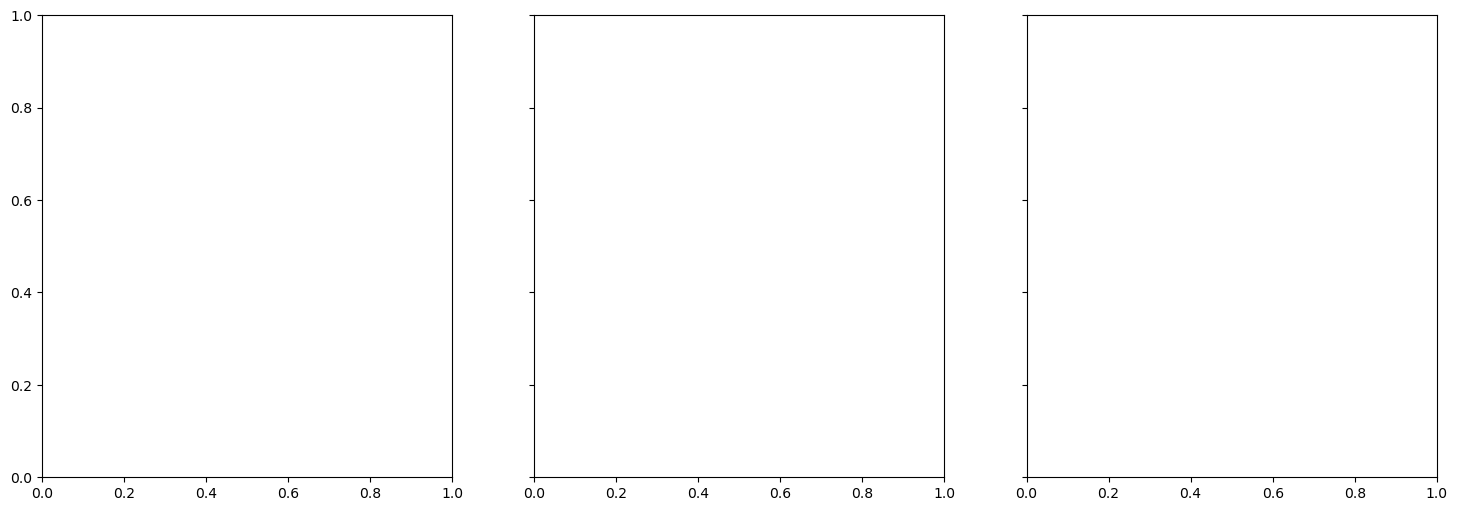

In [104]:
factor=3
# 计算横坐标的最大值和最小值
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for idx, param in enumerate([1, 5, 10]):
    x_min = min(all_reep[idx])-10
    x_max = max(all_reep[idx])+10
    re_exp = [pair[0] for pair in results_ea[param]]
    residuals_ea = [pair[1] for pair in results_ea[param]]
    residuals_eX = [pair[1] for pair in results_eX[param]]

    # 计算相对残差
    relative_residuals_ea = np.array(residuals_ea) / np.array(re_exp)
    relative_residuals_eX = np.array(residuals_eX) / np.array(re_exp)

    # 计算 MAE 和标准差
    mae_ea = np.mean(np.abs(relative_residuals_ea))
    std_dev_ea = np.std(relative_residuals_ea)
    mae_eX = np.mean(np.abs(relative_residuals_eX))
    std_dev_eX = np.std(relative_residuals_eX)

#     mask_ea = (relative_residuals_ea >= -factor * std_dev_ea) & (relative_residuals_ea <= factor * std_dev_ea)
#     mask_eX = (relative_residuals_eX >= -factor * std_dev_eX) & (relative_residuals_eX <= factor * std_dev_eX)
#     mask = mask_ea & mask_eX

#     re_exp = np.array(re_exp)[mask]
#     relative_residuals_ea = relative_residuals_ea[mask]
#     relative_residuals_eX = relative_residuals_eX[mask]
    # 绘制相对残差图
    axes[idx].scatter(re_exp, relative_residuals_ea, marker='D', s=70, c='red', edgecolor='black', alpha=0.6, label='Simulation vs. Expectation')
    axes[idx].scatter(re_exp, relative_residuals_eX, marker='o', s=70, c='blue', edgecolor='black', alpha=0.6, label='Expectation vs. SEA Regression')
    axes[idx].axhline(y=0, color='r', linestyle='--')
    axes[idx].set_xlim(x_min, x_max+10)  # 统一坐标轴
    axes[idx].set_ylim(-1, 1)  # 设置 y 轴范围为 -1 到 1
    axes[idx].set_xlabel('Expected Value (re_exp)')
    axes[idx].set_ylabel('Relative Residuals')
    axes[idx].set_title(f'n={param}, MAE(EA)={mae_ea:.2f}, STD(EA)={std_dev_ea:.2f}\nMAE(eX)={mae_eX:.2f}, STD(eX)={std_dev_eX:.2f}')
    axes[idx].legend()
    print(f"网络 {i+1} 参数 n={param} 的残差绝对平均值 (MAE) 和标准差 (STD):")
    print(f"EA: MAE={mae_ea:.2f}, STD={std_dev_ea:.2f}")
    print(f"eX: MAE={mae_eX:.2f}, STD={std_dev_eX:.2f}")

plt.suptitle(f'Residual Plot for {categories[i]}', fontdict=title_font)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_folder, f'network_{3}_residual_plot.png'))
plt.close()

In [107]:
print(re_exp)
print([exp for exp in re_exp if exp<100])

[557.2048212670354, 575.4889416525707, 596.3448913123401, 632.7766218118502, 328.4480758371047, 445.29703760363606, 518.6468058673045, 583.3163383141649, 552.2846743713359, 367.89406924590287, 587.0972715667139, 362.14278446690304, 557.5879655805255, 411.7268173450725, 488.9995072220584, 866.6092428873916, 687.5217403730995, 920.6349125094561, 893.9151654717319, 664.7938098180132, 615.5526674800783, 602.3600507889262, 584.548932519894, 627.3060326673028, 461.5318891452818, 262.06636625648576, 324.60065428193934, 356.0288917930576, 353.7464733966549, 176.91908757419546, 802.5870855458986, 699.0463093659484, 754.0610999017225, 716.4450533661203, 668.8454687606857, 564.6645657330882, 466.74616888806565, 390.5212467578466, 490.6034977480828, 409.9542887416786, 767.8263690233227, 749.2595333769405, 847.2598118589874, 782.7783204759855, 554.2560234662634, 676.4703226128207, 663.0114829565097, 610.287602724814, 746.2747089890994, 722.0690085968764, 660.287871449826, 536.104281873178, 559.0484

In [4]:
import time

current_dir = os.getcwd()
folder_name = "Test"
output_folder = "ForPaper"
folder_path = os.path.join(current_dir, folder_name)
output_path = os.path.join(current_dir, output_folder)

for filename in os.listdir(folder_path):
    
    start_time = time.time()
    file_path = os.path.join(folder_path, filename)
    edges = read_txt_network(file_path)
    G = nx.DiGraph()
    G.add_edges_from(edges)
    adj_matrix = nx.adjacency_matrix(G)
    pre = pr * adj_matrix.toarray()
    rho = compute_rho(pre)
    end_time = time.time()
    run_time = end_time - start_time
    run_time_min = run_time / 60
    print("Compute Rho", run_time_min, "minutes")
    
    for num_choice in [1, 5, 10]:
        start_time = time.time()
        result = Calcul_Residual(G, rho, pr, 10, num_choice)
        split_file = os.path.splitext(filename)
        new_filename = f"{num_choice}_{split_file[0]}{split_file[1]}"
        with open(os.path.join(output_path, new_filename), 'w') as file:
            for item in result:
                # 将每个子列表转换为字符串，并用空格分隔
                line = ' '.join(map(str, item))
                # 写入文件
                file.write(line + '\n')
        end_time = time.time()
        run_time = end_time - start_time
        run_time_min = run_time / 60
        print(new_filename + " Running time：", run_time_min, "minutes")

KeyboardInterrupt: 

In [52]:
current_dir = os.getcwd()
folder_name = "Test"
output_folder = "ForPaper"
folder_path = os.path.join(current_dir, folder_name)
output_path = os.path.join(current_dir, output_folder)
start_time = time.time()
file_path = os.path.join(folder_path, filename)
edges = read_txt_network(file_path)
G = nx.DiGraph()
G.add_edges_from(edges)
adj_matrix = nx.adjacency_matrix(G)
pre = pr * adj_matrix.toarray()
rho = compute_rho(pre)

KeyboardInterrupt: 

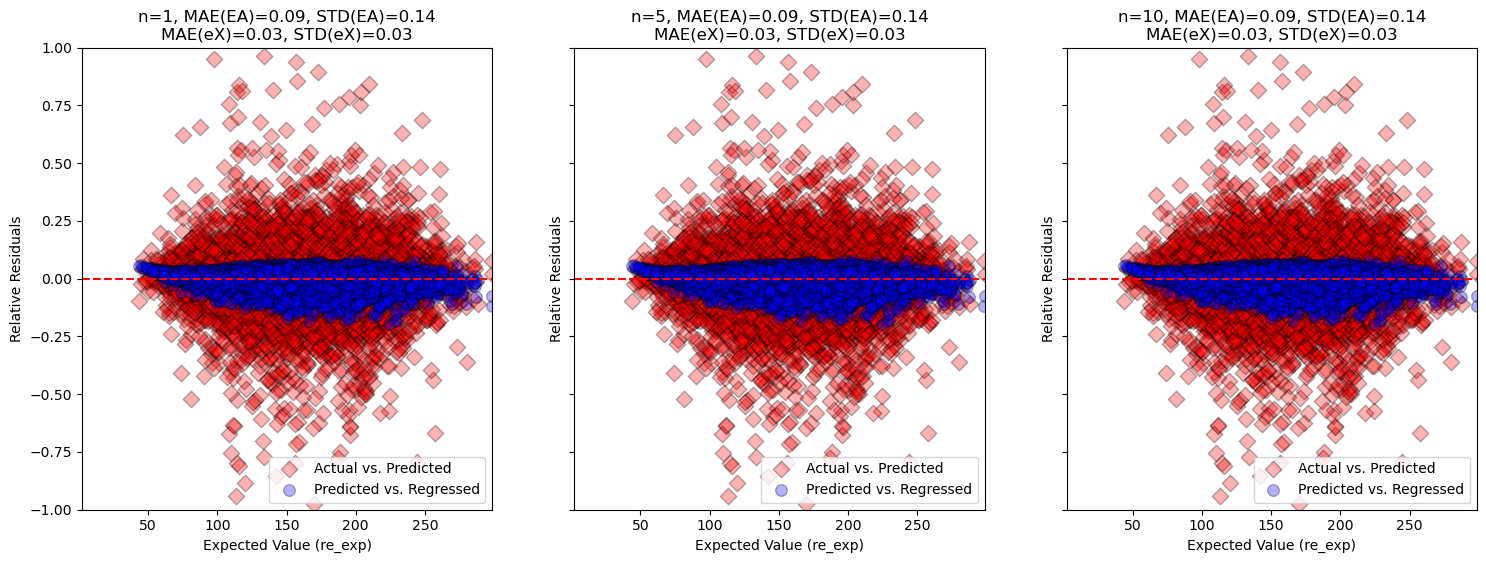

In [23]:
# ... (前面的代码保持不变)

for i in range(network_count):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for idx, param in enumerate([1, 5, 10]):
        re_exp = [pair[0] for pair in results_ea[param][i]]
        residuals_ea = [pair[1] for pair in results_ea[param][i]]
        residuals_eX = [pair[1] for pair in results_eX[param][i]]

        # 计算相对残差
        relative_residuals_ea = np.array(residuals_ea) / np.array(act)
        relative_residuals_eX = np.array(residuals_eX) / np.array(re_exp)

        # 计算 MAE 和标准差
        mae_ea = np.mean(np.abs(relative_residuals_ea))
        std_dev_ea = np.std(relative_residuals_ea)
        mae_eX = np.mean(np.abs(relative_residuals_eX))
        std_dev_eX = np.std(relative_residuals_eX)

        # 绘制相对残差图
        # 设置透明度 alpha=0.3 来减小离群点的视觉影响
        axes[idx].scatter(re_exp, relative_residuals_ea, marker='D', s=70, c='red', edgecolor='black', alpha=0.3, label='Actual vs. Predicted')
        axes[idx].scatter(re_exp, relative_residuals_eX, marker='o', s=70, c='blue', edgecolor='black', alpha=0.3, label='Predicted vs. Regressed')

        # 限制y轴范围，例如从-3到3的标准差范围内
        y_min, y_max = -1,1
        axes[idx].set_ylim(y_min, y_max)

        axes[idx].axhline(y=0, color='r', linestyle='--')
        axes[idx].set_xlim(x_min, x_max)  # 统一坐标轴
        axes[idx].set_xlabel('Expected Value (re_exp)')
        axes[idx].set_ylabel('Relative Residuals')
        axes[idx].set_title(f'n={param}, MAE(EA)={mae_ea:.2f}, STD(EA)={std_dev_ea:.2f}\nMAE(eX)={mae_eX:.2f}, STD(eX)={std_dev_eX:.2f}')
        axes[idx].legend()

    # ... (后面的代码保持不变)

In [115]:
print(n_Choices(G, 5, 5, pr, num_iterations))

{'sel': [564, 412, 229, 503, 600], 'dec': [0.9, 0.6, 0.3, 0.7, 0.7], 'act': 96.7125}
{'sel': [564, 412, 229, 503, 600], 'dec': [0.5, 0.5, 0.4, 0.8, 0.4], 'act': 65.9125}
{'sel': [564, 412, 229, 503, 600], 'dec': [0.9, 1.0, 0.8, 0.9, 0.4], 'act': 87.925}
{'sel': [564, 412, 229, 503, 600], 'dec': [0.7, 0.3, 0.7, 0.1, 0.2], 'act': 40.4375}
{'sel': [564, 412, 229, 503, 600], 'dec': [0.3, 1.0, 1.0, 0.6, 0.1], 'act': 48.675}
{'sel': [596, 649, 656, 469, 717], 'dec': [0.9, 0.6, 0.3, 0.7, 0.7], 'act': 163.3}
{'sel': [596, 649, 656, 469, 717], 'dec': [0.5, 0.5, 0.4, 0.8, 0.4], 'act': 150.0625}
{'sel': [596, 649, 656, 469, 717], 'dec': [0.9, 1.0, 0.8, 0.9, 0.4], 'act': 171.3}
{'sel': [596, 649, 656, 469, 717], 'dec': [0.7, 0.3, 0.7, 0.1, 0.2], 'act': 116.2125}
{'sel': [596, 649, 656, 469, 717], 'dec': [0.3, 1.0, 1.0, 0.6, 0.1], 'act': 169.9375}
{'sel': [289, 562, 604, 500, 400], 'dec': [0.9, 0.6, 0.3, 0.7, 0.7], 'act': 82.95}
{'sel': [289, 562, 604, 500, 400], 'dec': [0.5, 0.5, 0.4, 0.8, 0.4], '

Traceback (most recent call last):
  File "C:\Users\ThinkPad\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_1392\1349868528.py", line 1, in <module>
    print(n_Choices(G, 5, 5, pr, num_iterations))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_1392\1531740769.py", line -1, in n_Choices
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ThinkPad\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ThinkPad\anaconda3\Lib\site-packages\IPython\core\ultratb.py", line 1310, in structured_traceback
    return FormattedTB.structured_traceback(
    

In [42]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 输入和输出文件夹路径
input_folders = "F:/Jupyter/Social network/ForPaper/plot/"
output_folder = "F:/Jupyter/Social network/ForPaper"

os.makedirs(output_folder, exist_ok=True)

# 初始化结果字典
results_ea = {1: [], 5: [], 10: []}
results_eX = {1: [], 5: [], 10: []}
all_reep = []

# 读取文件并处理数据
for filename in os.listdir(input_folders):
    if filename.endswith('.txt'):
        file_path = os.path.join(input_folders, filename)
        data = pd.read_csv(file_path, sep=' ', header=None)
        
        # 提取数据
        act = data.iloc[:, 0]
        exp = data.iloc[:, 1].values.reshape(-1, 1)  # 转换为二维数组
        X = data.iloc[:, 2:]
        
        for param in [1, 5, 10]:
            # 对 exp 进行线性回归
            lin_reg_ea = LinearRegression()
            lin_reg_ea.fit(exp, act)
            re_exp = lin_reg_ea.predict(exp)
            
            # 计算实际值与预测值的残差
            residuals_ea = list(zip(re_exp, act - re_exp))
            results_ea[param].append(residuals_ea)
            
            # 对 X 进行线性回归
            lin_reg_eX = LinearRegression()
            lin_reg_eX.fit(X, re_exp)
            re_X = lin_reg_eX.predict(X)
            
            # 计算预测值与回归值的残差
            residuals_eX = list(zip(re_exp, re_X - re_exp))
            results_eX[param].append(residuals_eX)
            
            # 存储所有的 re_exp 值以便确定横坐标范围
            all_reep.extend(re_exp)

# 计算横坐标的最大值和最小值
x_min = min(all_reep)
x_max = max(all_reep)

# 绘制相对残差图
categories = ['Caltech47']
network_count = len(categories)
title_font = {
    'size': 40,  # 设置字号为20
    'weight': 'bold',  # 设置为粗体
    'family': 'serif',  # 设置字体为衬线字体
    'color': 'blue'  # 设置字体颜色为蓝色
}

for i in range(network_count):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for idx, param in enumerate([1, 5, 10]):
        re_exp = [pair[0] for pair in results_ea[param][i]]
        residuals_ea = [pair[1] for pair in results_ea[param][i]]
        residuals_eX = [pair[1] for pair in results_eX[param][i]]
        
        # 计算相对残差
        relative_residuals_ea = np.array(residuals_ea) / np.array(re_exp)
        relative_residuals_eX = np.array(residuals_eX) / np.array(re_exp)
        
        # 计算 MAE 和标准差
        mae_ea = np.mean(np.abs(relative_residuals_ea))
        std_dev_ea = np.std(relative_residuals_ea)
        mae_eX = np.mean(np.abs(relative_residuals_eX))
        std_dev_eX = np.std(relative_residuals_eX)
        
        # 绘制相对残差图
        axes[idx].scatter(re_exp, relative_residuals_ea, marker='D', s=70, c='red', edgecolor='black', alpha=0.7, label='Actual vs. Predicted')
        axes[idx].scatter(re_exp, relative_residuals_eX, marker='o', s=70, c='blue', edgecolor='black', alpha=0.7, label='Predicted vs. Regressed')
        axes[idx].axhline(y=0, color='r', linestyle='--')
        axes[idx].set_xlim(x_min, x_max)  # 统一坐标轴
        axes[idx].set_xlabel('Expected Value (re_exp)')
        axes[idx].set_ylabel('Relative Residuals')
        axes[idx].set_title(f'n={param}, MAE(EA)={mae_ea:.2f}, STD(EA)={std_dev_ea:.2f}\nMAE(eX)={mae_eX:.2f}, STD(eX)={std_dev_eX:.2f}')
        axes[idx].legend()

    plt.suptitle(f'Residual Plot for {categories[i]}', fontdict=title_font)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(output_folder, f'network_{i+1}_residual_plot.png'))
    plt.close()

    print(f"网络 {i+1} 参数 n={param} 的残差绝对平均值 (MAE) 和标准差 (STD):")
    print(f"EA: MAE={mae_ea:.2f}, STD={std_dev_ea:.2f}")
    print(f"eX: MAE={mae_eX:.2f}, STD={std_dev_eX:.2f}")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [132]:
import re

line='sel: [567] dec: [0.3] act: 21.1625'

pattern = r'sel:\s*\[(.*?)\]\s*dec:\s*\[(.*?)\]\s*act:\s*(\d+\.\d+)'
    
# 使用正则表达式匹配行内容
match = re.match(pattern, line)

if not match:
    raise ValueError(f"Invalid line format: {line}")

# 提取匹配的组
sel_part, dec_part, act_part = match.groups()

# 提取 selected 节点列表
selected = [int(node.strip()) for node in sel_part.split(',')]

# 提取 frequency 列表
frequency = [float(freq.strip()) for freq in dec_part.split(',')]

# 提取实际激活节点数
act = float(act_part)

print(sel_part)
print(dec_part)
print(act)

decision_dict = dict(zip(selected, frequency))

print(decision_dict)
exp = Expected_Activated_Matrix(G, decision_dict, rho)
act = ICsim(G, decision_dict , pr, num_iterations)
print(exp)
print(act)


567
0.3
21.1625
{567: 0.3}
25.691144491683417
17.2


In [72]:
print(line)
parts = line.strip().split(',')
print(parts)
for part in parts:
    if part.startswith('sel:'):
        sel_part = part
    elif part.startswith('dec:'):
        dec_part = part
    elif part.startswith('act:'):
        act_part = part
        

sel: [732, 589, 424, 710, 668, 642, 602, 334, 463, 295] dec: [0.3, 0.2, 0.1, 1.0, 0.6, 0.5, 0.4, 1.0, 0.4, 0.2] act: 4.98
['sel: [732', ' 589', ' 424', ' 710', ' 668', ' 642', ' 602', ' 334', ' 463', ' 295] dec: [0.3', ' 0.2', ' 0.1', ' 1.0', ' 0.6', ' 0.5', ' 0.4', ' 1.0', ' 0.4', ' 0.2] act: 4.98']
sel: [732
dec:


In [19]:
a=[1,5,10][1]
print(a)

5


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 输入和输出文件夹路径
input_folders = ["F:/Jupyter/Social network/Choices_Multi_new/Multi_2", 
                 "F:/Jupyter/Social network/Choices_Multi_new/Multi_10",
                 "F:/Jupyter/Social network/Choices_Multi_new/Multi_20"]
output_folder = "F:/Jupyter/Social network/ForPaper"

# 确保输出文件夹存在
os.makedirs(output_folder, exist_ok=True)

# 获取文件夹中的所有文件并按参数分组
network_data = {2: [], 10: [], 20: []}
for idx, input_folder in enumerate(input_folders):
    param = [2, 10, 20][idx]
    files = sorted([f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))])
    for file in files:
        file_path = os.path.join(input_folder, file)
        network_data[param].append(file_path)

# 遍历每个文件进行回归分析
results = {2: [], 10: [], 20: []}
all_actuals = []
for param in [2, 10, 20]:
    for file_path in network_data[param]:
        # 读取数据
        data = pd.read_csv(file_path, sep=' ', header=None)
        
        # 假设最后一列是因变量，前面的列是自变量
        X = data.iloc[:, :-1]
        y = data.iloc[:, -1]
        
        # 创建线性回归模型
        lin_reg = LinearRegression()
        
        # 训练模型
        lin_reg.fit(X, y)
        
        # 计算预测值
        y_pred = lin_reg.predict(X)
        
        # 存储实际值和残差对
        residuals = list(zip(y, y_pred- y ))
        results[param].append(residuals)
        
        # 存储所有的实际值以便确定横坐标范围
        all_actuals.extend(y)

# 计算横坐标的最大值和最小值
x_min = min(all_actuals)
x_max = max(all_actuals)

# 绘制以实际值为横轴的残差图，并计算残差绝对平均值
network_count = len(results[2])  # 假设所有参数的网络数量相同

categories = ['American75', 'Amherst41', 'Bingham82', 'Bowdoin47','Brandeis99', 'Caltech47', 'Combined']
title_font = {
    'size': 40,  # 设置字号为20
    'weight': 'bold',  # 设置为粗体
    'family': 'serif',  # 设置字体为衬线字体
    'color': 'blue'  # 设置字体颜色为蓝色
}

for i in range(network_count):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for idx, param in enumerate([2, 10, 20]):
        actuals = [pair[0] for pair in results[param][i]]
        residuals = [pair[1] for pair in results[param][i]]
        relative_residuals=np.array(residuals)/np.array(actuals)
        mae = np.mean(np.abs(residuals))
        std_dev = np.std(residuals)
        
        axes[idx].scatter(actuals, relative_residuals, marker='D', s=70, c='red', edgecolor='black', alpha=0.7)
        axes[idx].axhline(y=0, color='r', linestyle='--')
        # axes[idx].set_xlim(x_min, x_max) 统一坐标轴
        axes[idx].set_xlabel('Actual Value')
        axes[idx].set_ylabel('Relative Residuals')
        axes[idx].set_title(f'n={param}, MAE={mae:.2f},STD={std_dev:.2f}')
        
        print(f"网络 {i+1} 参数 n={param} 的残差绝对平均值 (MAE): {mae:.2f}，标准差 (STD): {std_dev:.2f}")
        
    plt.suptitle(f'Residual Plot for {categories[i]}',fontdict=title_font)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(output_folder, f'network_{i+1}_residual_plot.png'))
    plt.close()

网络 1 参数 n=2 的残差绝对平均值 (MAE): 143.60，标准差 (STD): 178.67
网络 1 参数 n=10 的残差绝对平均值 (MAE): 45.92，标准差 (STD): 57.79
网络 1 参数 n=20 的残差绝对平均值 (MAE): 31.69，标准差 (STD): 39.71
网络 2 参数 n=2 的残差绝对平均值 (MAE): 68.30，标准差 (STD): 85.38
网络 2 参数 n=10 的残差绝对平均值 (MAE): 18.02，标准差 (STD): 22.68
网络 2 参数 n=20 的残差绝对平均值 (MAE): 13.58，标准差 (STD): 17.08
网络 3 参数 n=2 的残差绝对平均值 (MAE): 260.05，标准差 (STD): 321.50
网络 3 参数 n=10 的残差绝对平均值 (MAE): 79.79，标准差 (STD): 100.25
网络 3 参数 n=20 的残差绝对平均值 (MAE): 49.57，标准差 (STD): 62.20
网络 4 参数 n=2 的残差绝对平均值 (MAE): 56.31，标准差 (STD): 72.44
网络 4 参数 n=10 的残差绝对平均值 (MAE): 16.49，标准差 (STD): 20.64
网络 4 参数 n=20 的残差绝对平均值 (MAE): 12.32，标准差 (STD): 15.76
网络 5 参数 n=2 的残差绝对平均值 (MAE): 137.17，标准差 (STD): 176.04
网络 5 参数 n=10 的残差绝对平均值 (MAE): 38.28，标准差 (STD): 48.30
网络 5 参数 n=20 的残差绝对平均值 (MAE): 28.43，标准差 (STD): 35.65
网络 6 参数 n=2 的残差绝对平均值 (MAE): 10.25，标准差 (STD): 13.57
网络 6 参数 n=10 的残差绝对平均值 (MAE): 7.03，标准差 (STD): 8.88
网络 6 参数 n=20 的残差绝对平均值 (MAE): 5.97，标准差 (STD): 7.50


In [41]:
all_reep = []
a=[1,2,3]
all_reep.extend(a)
print(all_reep)

[1, 2, 3]


In [59]:
print(i)

0
